In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

## Stock to test the support and resistance, and compare with the classic trade strategy
* yinn
* kweb
* tqqq
* sark

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'yinn')

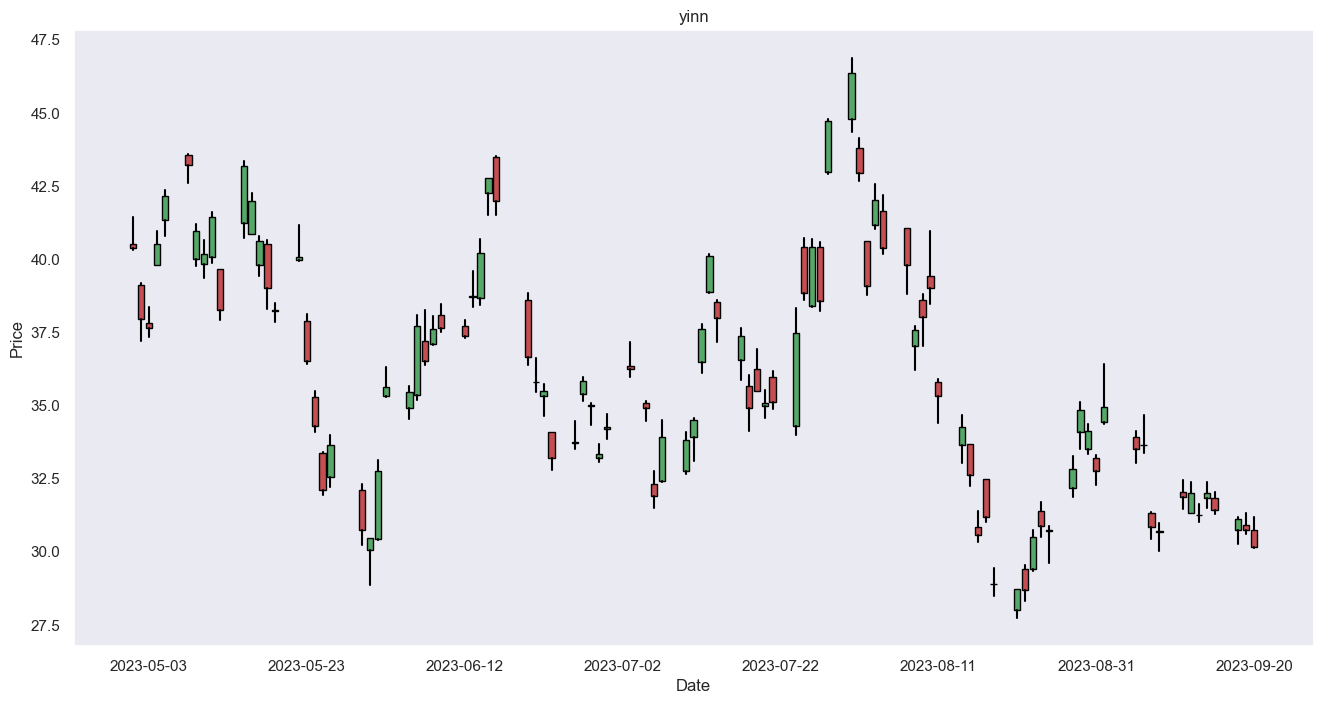

In [3]:
df_yinn = yf.download('yinn'.upper(), start='2023-05-01', end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')

Optimum K is 10
Optimum K is 10
[[28.54599991]
 [30.25800018]
 [31.64333328]
 [33.08272726]
 [34.3566672 ]
 [35.82750003]
 [37.38444434]
 [38.66749986]
 [40.5208327 ]
 [43.13999844]]
[[29.24666659]
 [31.17545457]
 [32.72363697]
 [34.43937516]
 [36.06583341]
 [38.22764722]
 [40.6400001 ]
 [42.17714255]
 [43.88199921]
 [46.86999893]]


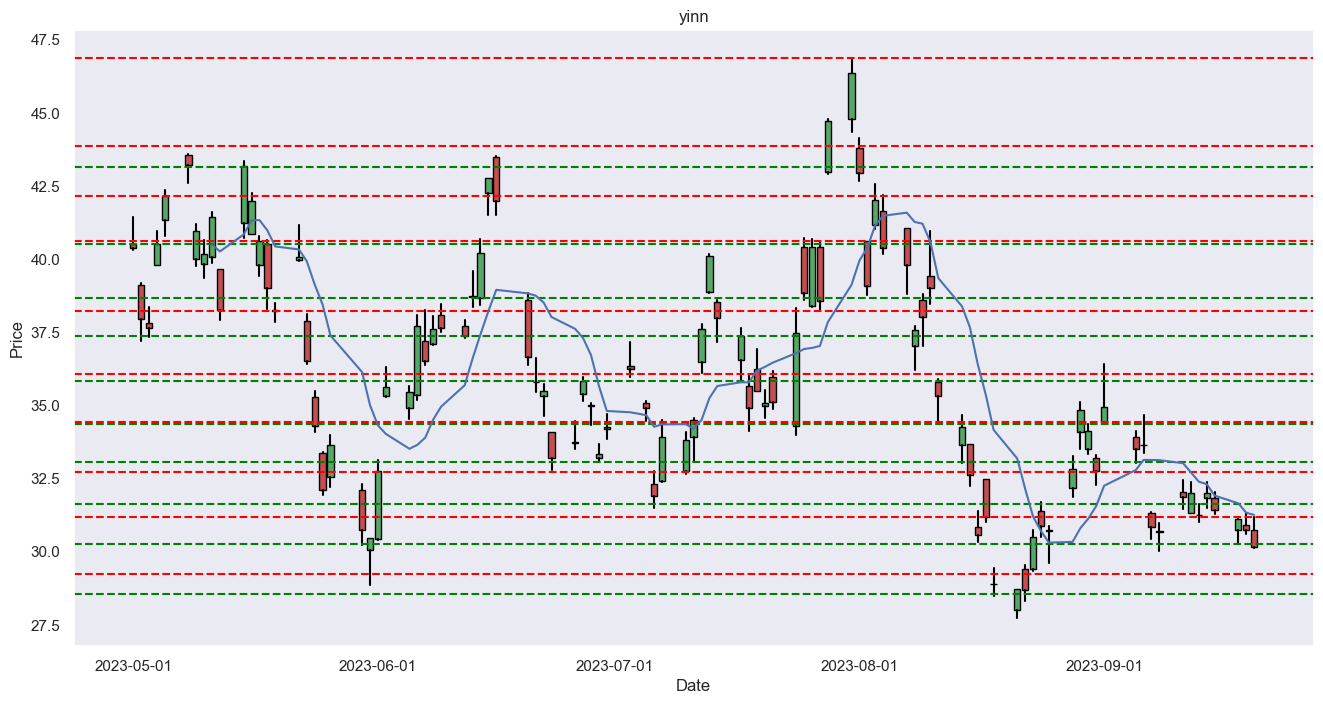

In [4]:
low_clusters = get_optimum_clusters(df_yinn[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

df_yinn['20_MA'] = df_yinn['Close'].rolling(window=9).mean()
ax.plot(df_yinn['Date'], df_yinn['20_MA'])

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
[[22.225     ]
 [29.93100001]
 [33.77521731]
 [37.68690491]
 [40.48814802]
 [43.70971407]
 [46.85100009]
 [54.46083323]
 [62.05000005]
 [69.3519989 ]]
[[23.97900028]
 [31.20178604]
 [34.9521429 ]
 [38.38137949]
 [41.49217373]
 [46.20666667]
 [49.9333334 ]
 [55.90428598]
 [63.49437499]
 [70.84428733]]


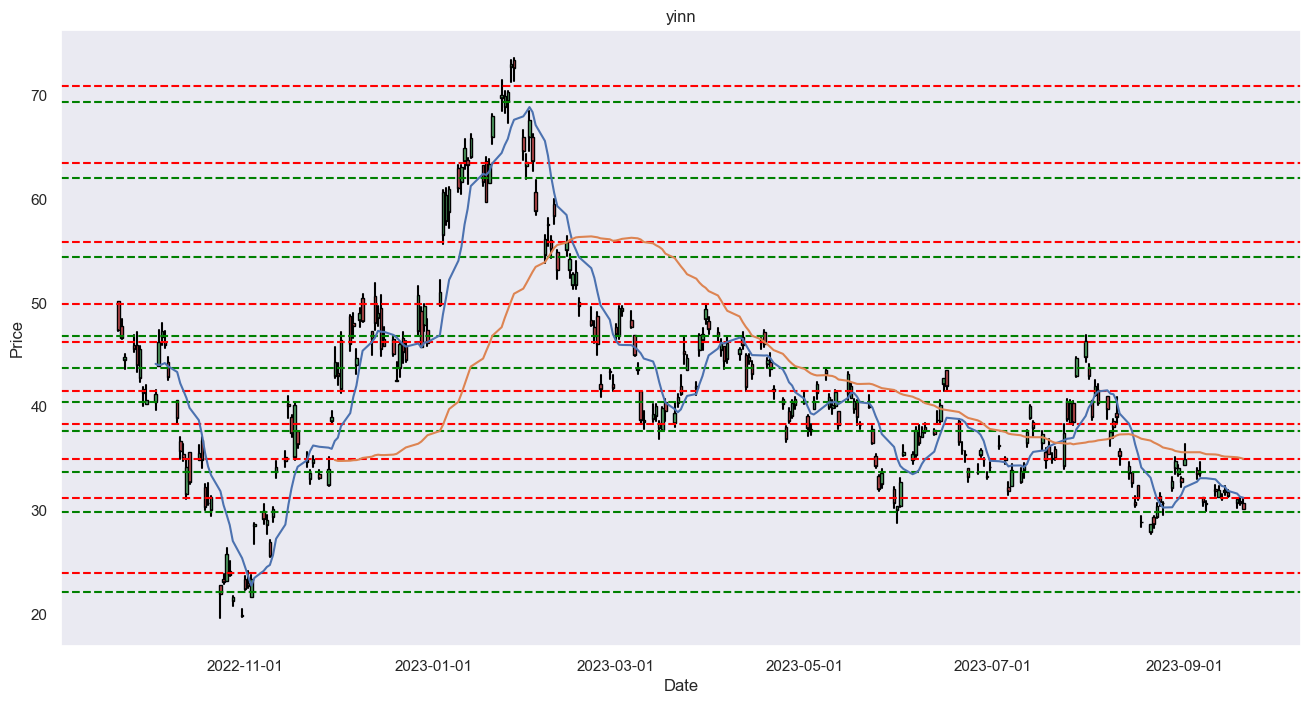

In [5]:
df_yinn = yf.download('yinn'.upper(), start='2022-09-21', end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

low_clusters = get_optimum_clusters(df_yinn[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')

print(low_centers)
print(high_centers)

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

df_yinn['9_MA'] = df_yinn['Close'].rolling(window=9).mean()
    
df_yinn['50_MA'] = df_yinn['Close'].rolling(window=50).mean()
ax.plot(df_yinn['Date'], df_yinn['9_MA'])
ax.plot(df_yinn['Date'], df_yinn['50_MA'])

In [6]:
records_df, purchase_record = stock_trading_strategy_supp_resist(
    df_yinn.rename(columns={'Date':'date','Close':'daily_price'}),
    [e[0] for e in low_centers if e <= df_yinn.iloc[0]['Close']],
    [e[0] for e in high_centers],
    initial_cash=10000,
    investment=1000,
)
print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
print(records_df['total_cash'].min())
records_df[records_df['action']!='Pass']

1774.9018599991014
3141.239323991829


,date,daily_price,low,high,action,action_price,action_unit,total_cash,total_num_shares
1,2022-09-22,46.660000,46.540001,48.439999,Purchase,46.851000,21.344262,9000.000000,2.134426e+01
2,2022-09-23,44.790001,43.689999,45.090000,Purchase,43.709714,22.878210,8000.000000,4.422247e+01
6,2022-09-29,41.320000,40.049999,41.910000,Purchase,40.488148,24.698586,7000.000000,6.892106e+01
9,2022-10-04,46.259998,43.950001,47.410000,Sell,46.206667,24.698586,8141.239324,4.422247e+01
13,2022-10-10,38.950001,38.470001,40.669998,Purchase,40.488148,24.698586,7141.239324,6.892106e+01
14,2022-10-11,35.759998,34.970001,37.139999,Purchase,37.686905,26.534416,6141.239324,9.545547e+01
16,2022-10-13,34.189999,31.129999,34.939999,Purchase,33.775217,29.607508,5141.239324,1.250630e+02
22,2022-10-21,31.309999,29.480000,31.430000,Purchase,29.931000,33.410177,4141.239324,1.584732e+02
23,2022-10-24,21.990000,19.660000,22.889999,Purchase,22.225000,44.994376,3141.239324,2.034675e+02
37,2022-11-11,34.240002,33.169998,34.830002,Sell,31.201786,44.994376,4545.144208,1.584732e+02


In [7]:
result = stock_trading_strategy(df_yinn.rename(columns={'Date':'date','Close':'daily_price'}),
                                '2023-05-01',
                                datetime.today().strftime('%Y-%m-%d'),
                                10000, 1000,
                                buy_threshold=0.05,
                                sell_threshold=0.1)

print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
print(result['total_cash'].min())
result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]
# 11024.60529658459
# 5238.617782091438

10878.396892262113
5238.617782091438


,date,daily_price,action,total_cash,total_num_shares
0,2023-05-01,40.380001,Purchase,9000.000000,2.476473e+01
1,2023-05-02,37.970001,Purchase,8000.000000,5.110132e+01
4,2023-05-05,42.169998,Sell,9110.613558,2.476473e+01
9,2023-05-12,38.279999,Purchase,8110.613558,5.088804e+01
10,2023-05-15,43.180000,Sell,9238.617782,2.476473e+01
14,2023-05-19,38.259998,Purchase,8238.617782,5.090169e+01
17,2023-05-24,34.299999,Purchase,7238.617782,8.005621e+01
18,2023-05-25,32.119999,Purchase,6238.617782,1.111895e+02
21,2023-05-31,30.469999,Purchase,5238.617782,1.440086e+02
23,2023-06-02,35.639999,Sell,6408.292879,1.111895e+02


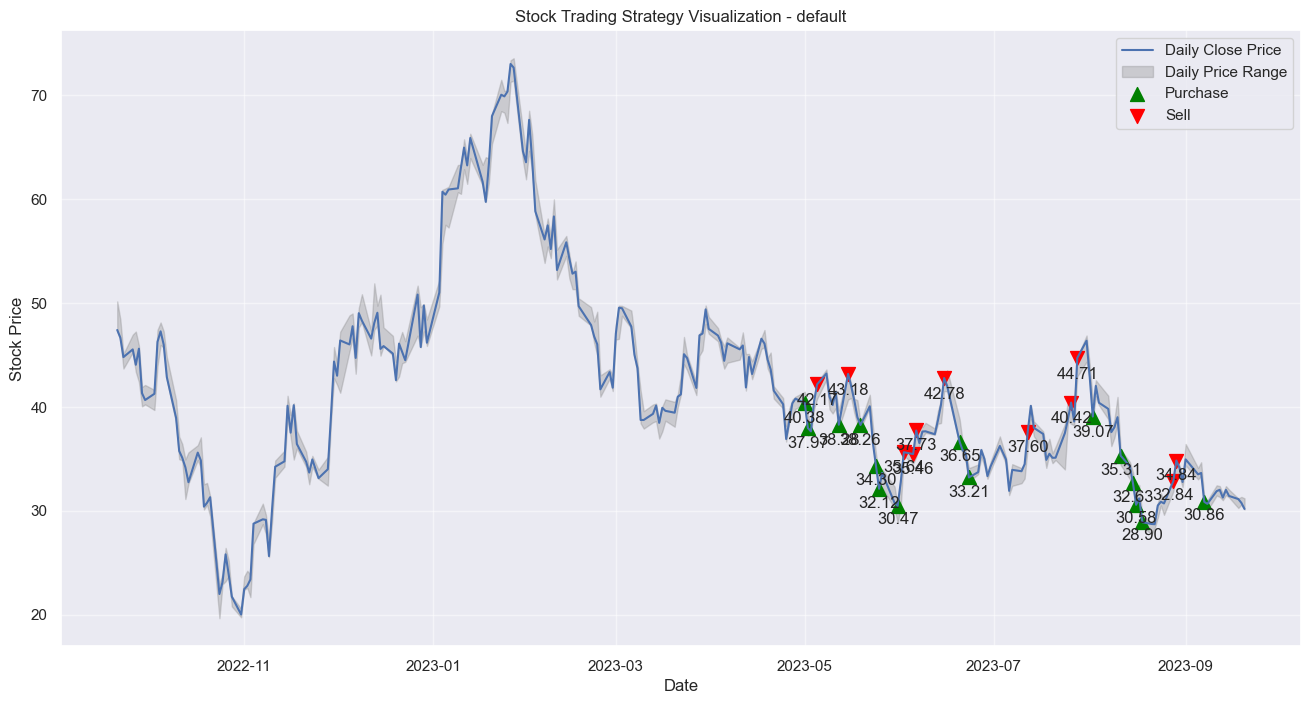

In [8]:
plt.figure(figsize=(16, 8))
plt.grid(True, alpha=0.5)

plt.plot(df_yinn['Date'], df_yinn['Close'], label='Daily Close Price')
# plt.plot(df_yinn['Date'], df_yinn['High'], color='green', label='Highest Price')
# plt.plot(df_yinn['Date'], df_yinn['Low'], color='red', label='Lowest Price')

# Shading the region between the highest and lowest prices
plt.fill_between(df_yinn['Date'], df_yinn['Low'], df_yinn['High'], color='gray', alpha=0.3, label='Daily Price Range')

result['date'] = pd.to_datetime(result['date'])

# plot the purchase actions as red dots
purchases = result[result['action'] == 'Purchase']
plt.scatter(purchases['date'], purchases['daily_price'], s=100, marker='^', color='green', label='Purchase')

# plot the sell actions as blue dots
sells = result[result['action'] == 'Sell']
plt.scatter(sells['date'], sells['daily_price'], s=100, marker='v', color='red', label='Sell')

for index, row in sells.iterrows():
    # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
    plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                 xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')
for index, row in purchases.iterrows():
    # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
    plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                 xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Trading Strategy Visualization - default')
plt.legend()

plt.show()

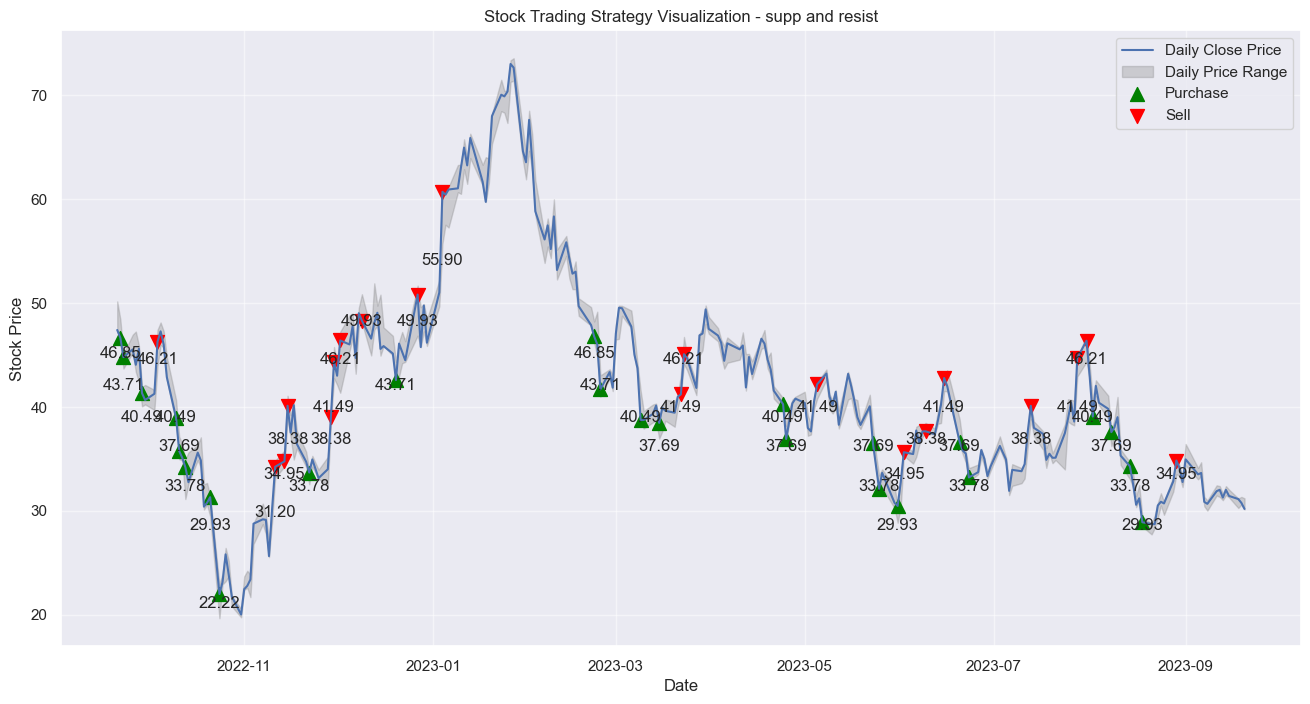

In [9]:
plt.figure(figsize=(16, 8))
plt.grid(True, alpha=0.5)

plt.plot(df_yinn['Date'], df_yinn['Close'], label='Daily Close Price')
# plt.plot(df_yinn['Date'], df_yinn['High'], color='green', label='Highest Price')
# plt.plot(df_yinn['Date'], df_yinn['Low'], color='red', label='Lowest Price')

# Shading the region between the highest and lowest prices
plt.fill_between(df_yinn['Date'], df_yinn['Low'], df_yinn['High'], color='gray', alpha=0.3, label='Daily Price Range')

records_df['date'] = pd.to_datetime(records_df['date'])

# plot the purchase actions as red dots
purchases = records_df[records_df['action'] == 'Purchase']
plt.scatter(purchases['date'], purchases['daily_price'], s=100, marker='^', color='green', label='Purchase')

# plot the sell actions as blue dots
sells = records_df[records_df['action'] == 'Sell']
plt.scatter(sells['date'], sells['daily_price'], s=100, marker='v', color='red', label='Sell')

for index, row in sells.iterrows():
    # plt.text(row['date'], row['action_price'], row['action_price'], ha='center', va='bottom')
    plt.annotate(f"{row['action_price']:.2f}", xy=(row['date'], row['action_price']), 
                 xytext=(row['date'], row['action_price']*0.98), ha='center', va='top')
for index, row in purchases.iterrows():
    # plt.text(row['date'], row['action_price'], row['action_price'], ha='center', va='bottom')
    plt.annotate(f"{row['action_price']:.2f}", xy=(row['date'], row['action_price']), 
                 xytext=(row['date'], row['action_price']*0.98), ha='center', va='top')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Trading Strategy Visualization - supp and resist')
plt.legend()

plt.show()

In [10]:
df_kweb = yf.download('kweb'.upper(), start='2023-05-01', end=datetime.today().strftime('%Y-%m-%d'))
df_kweb = df_kweb.reset_index()

low_clusters = get_optimum_clusters(df_kweb[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_kweb[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

records_df, purchase_record = stock_trading_strategy_supp_resist(
    df_kweb.rename(columns={'Date':'date','Close':'daily_price'}),
    [e[0] for e in low_centers if e <= df_kweb.iloc[0]['Close']],
    [e[0] for e in high_centers],
    initial_cash=10000,
    investment=1000,
)
print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
print(records_df['total_cash'].min())
records_df[records_df['action']!='Pass']

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
314.7101045939344
8000.0


,date,daily_price,low,high,action,action_price,action_unit,total_cash,total_num_shares
0,2023-05-01,27.870001,27.770000,28.205000,Purchase,27.819250,35.946332,9000.000000,3.594633e+01
18,2023-05-25,25.330000,25.264999,25.865000,Purchase,25.637500,39.005364,8000.000000,7.495170e+01
30,2023-06-13,28.459999,28.379999,29.025000,Sell,28.479444,39.005364,9110.851078,3.594633e+01
61,2023-07-28,31.740000,30.889999,31.750000,Sell,31.000250,35.946332,10225.196356,7.105427e-15
74,2023-08-16,27.629999,27.330000,27.959999,Purchase,27.410875,36.481871,9225.196356,3.648187e+01
86,2023-09-01,29.709999,29.250000,30.260000,Sell,30.185400,36.481871,10326.416222,7.105427e-15
89,2023-09-07,27.670000,27.395000,27.962000,Purchase,27.410875,36.481871,9326.416222,3.648187e+01


In [11]:
result = stock_trading_strategy(df_kweb.rename(columns={'Date':'date','Close':'daily_price'}),
                                '2023-05-01',
                                datetime.today().strftime('%Y-%m-%d'),
                                10000, 1000,
                                buy_threshold=0.05,
                                sell_threshold=0.1)

print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
print(result['total_cash'].min())
result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]

10342.905133016005
7000.0


,date,daily_price,action,total_cash,total_num_shares
0,2023-05-01,27.870001,Purchase,9000.000000,3.588087e+01
16,2023-05-23,26.299999,Purchase,8000.000000,7.390369e+01
21,2023-05-31,24.950001,Purchase,7000.000000,1.139838e+02
25,2023-06-06,27.730000,Sell,8111.422793,7.390369e+01
31,2023-06-14,29.250000,Sell,9223.590126,3.588087e+01
61,2023-07-28,31.740000,Sell,10362.449072,-7.105427e-15
74,2023-08-16,27.629999,Purchase,9362.449072,3.619255e+01


In [12]:
df_tqqq = yf.download('tqqq'.upper(), start='2023-07-07', end=datetime.today().strftime('%Y-%m-%d'))
df_tqqq = df_tqqq.reset_index()

low_clusters = get_optimum_clusters(df_tqqq[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_tqqq[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

records_df, purchase_record = stock_trading_strategy_supp_resist(
    df_tqqq.rename(columns={'Date':'date','Close':'daily_price'}),
    [e[0] for e in low_centers if e <= df_tqqq.iloc[0]['Close']],
    [e[0] for e in high_centers],
    initial_cash=10000,
    investment=1000,
)
print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
print(records_df['total_cash'].min())
records_df[records_df['action']!='Pass']

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
192.16108026915572
8119.292289542011


,date,daily_price,low,high,action,action_price,action_unit,total_cash,total_num_shares
1,2023-07-10,39.900002,38.930000,40.110001,Purchase,39.376667,25.395750,9000.00000,25.395750
4,2023-07-13,44.060001,42.830002,44.360001,Sell,44.074000,25.395750,10119.29229,0.000000
24,2023-08-10,39.889999,39.369999,41.750000,Purchase,39.376667,25.395750,9119.29229,25.395750
30,2023-08-18,36.400002,35.369999,36.810001,Purchase,36.214999,27.612868,8119.29229,53.008618
34,2023-08-24,37.160000,37.099998,40.910000,Sell,40.350000,27.612868,9233.47151,25.395750


In [13]:
result = stock_trading_strategy(df_tqqq.rename(columns={'Date':'date','Close':'daily_price'}),
                                '2023-07-07',
                                datetime.today().strftime('%Y-%m-%d'),
                                10000, 1000,
                                buy_threshold=0.05,
                                sell_threshold=0.1)

print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
print(result['total_cash'].min())
result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]

10186.988896511
8105.091611579037


,date,daily_price,action,total_cash,total_num_shares
0,2023-07-07,39.869999,Purchase,9000.000000,25.081516
4,2023-07-13,44.060001,Sell,10105.091612,0.000000
23,2023-08-09,39.709999,Purchase,9105.091612,25.182574
29,2023-08-17,36.570000,Purchase,8105.091612,52.527393
37,2023-08-29,41.369999,Sell,9236.346719,25.182574


In [14]:
df_sark = yf.download('sark'.upper(), start='2023-06-29', end=datetime.today().strftime('%Y-%m-%d'))
df_sark = df_sark.reset_index()

low_clusters = get_optimum_clusters(df_sark[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_sark[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

records_df, purchase_record = stock_trading_strategy_supp_resist(
    df_sark.rename(columns={'Date':'date','Close':'daily_price'}),
    [e[0] for e in low_centers if e <= df_sark.iloc[0]['Close']],
    [e[0] for e in high_centers],
    initial_cash=10000,
    investment=1000,
)
print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
print(records_df['total_cash'].min())
records_df[records_df['action']!='Pass']

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
304.8895583129761
7000.0


,date,daily_price,low,high,action,action_price,action_unit,total_cash,total_num_shares
0,2023-06-29,36.450001,35.869999,36.599998,Purchase,36.008333,27.771349,9000.000000,27.771349
7,2023-07-11,33.810001,33.639999,35.040001,Purchase,33.746667,29.632556,8000.000000,57.403905
10,2023-07-14,32.720001,31.520000,32.930000,Purchase,31.802500,31.444068,7000.000000,88.847974
28,2023-08-09,36.349998,35.169998,36.410000,Sell,35.851750,31.444068,8127.324875,57.403905
31,2023-08-14,36.680000,36.680000,37.599998,Sell,37.309999,29.632556,9232.915517,27.771349


In [15]:
result = stock_trading_strategy(df_sark.rename(columns={'Date':'date','Close':'daily_price'}),
                                '2023-06-29',
                                datetime.today().strftime('%Y-%m-%d'),
                                10000, 1000,
                                buy_threshold=0.05,
                                sell_threshold=0.1)

print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
print(result['total_cash'].min())
result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]

10299.32923896285
7000.0


,date,daily_price,action,total_cash,total_num_shares
0,2023-06-29,36.450001,Purchase,9000.000000,27.434842
7,2023-07-11,33.810001,Purchase,8000.000000,57.011889
9,2023-07-13,32.000000,Purchase,7000.000000,88.261889
28,2023-08-09,36.349998,Sell,8135.937452,57.011889
32,2023-08-15,37.340000,Sell,9240.344392,27.434842


In [16]:
df_cof = yf.download('cof'.upper(), start='2022-09-19', end=datetime.today().strftime('%Y-%m-%d'))
df_cof = df_cof.reset_index()

low_clusters = get_optimum_clusters(df_cof[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_cof[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

records_df, purchase_record = stock_trading_strategy_supp_resist(
    df_cof.rename(columns={'Date':'date','Close':'daily_price'}),
    [e[0] for e in low_centers if e <= df_cof.iloc[0]['Close']],
    [e[0] for e in high_centers],
    initial_cash=10000,
    investment=1000,
)
print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
print(records_df['total_cash'].min())
records_df[records_df['action']!='Pass']

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
963.5171555310062
7231.163647650421


,date,daily_price,low,high,action,action_price,action_unit,total_cash,total_num_shares
0,2022-09-19,102.480003,99.790001,102.849998,Purchase,101.861154,9.817285,9000.000000,9.817285
3,2022-09-22,95.470001,95.349998,99.959999,Purchase,96.147600,10.400676,8000.000000,20.217961
29,2022-10-28,107.099998,98.510002,107.419998,Sell,106.968001,10.400676,9112.539485,9.817285
38,2022-11-10,113.419998,106.550003,114.120003,Sell,113.944348,9.817285,10231.163648,0.000000
42,2022-11-16,101.760002,100.160004,104.230003,Purchase,101.861154,9.817285,9231.163648,9.817285
54,2022-12-05,95.019997,94.089996,96.889999,Purchase,96.147600,10.400676,8231.163648,20.217961
63,2022-12-16,90.099998,89.220001,92.790001,Purchase,90.255000,11.079719,7231.163648,31.297679
81,2023-01-13,102.849998,98.629997,103.360001,Sell,103.017059,11.079719,8372.563666,20.217961
86,2023-01-23,107.120003,103.800003,107.349998,Sell,106.968001,10.400676,9485.103152,9.817285
88,2023-01-25,116.089996,103.110001,116.680000,Sell,113.944348,9.817285,10603.727314,0.000000


In [17]:
result = stock_trading_strategy(df_cof.rename(columns={'Date':'date','Close':'daily_price'}),
                                '2022-09-19',
                                datetime.today().strftime('%Y-%m-%d'),
                                10000, 1000,
                                buy_threshold=0.05,
                                sell_threshold=0.1)

print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
print(result['total_cash'].min())
result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]

10968.19015806394
7228.570824896


,date,daily_price,action,total_cash,total_num_shares
0,2022-09-19,102.480003,Purchase,9000.000000,9.758001e+00
3,2022-09-22,95.470001,Purchase,8000.000000,2.023250e+01
29,2022-10-28,107.099998,Sell,9121.818342,9.758001e+00
38,2022-11-10,113.419998,Sell,10228.570825,0.000000e+00
42,2022-11-16,101.760002,Purchase,9228.570825,9.827044e+00
54,2022-12-05,95.019997,Purchase,8228.570825,2.035114e+01
63,2022-12-16,90.099998,Purchase,7228.570825,3.144992e+01
79,2023-01-11,101.790001,Sell,8358.315582,2.035114e+01
86,2023-01-23,107.120003,Sell,9485.657263,9.827044e+00
88,2023-01-25,116.089996,Sell,10626.478744,-1.776357e-15


### Try a different approach to calculate support and resistance

[*********************100%***********************]  1 of 1 completed


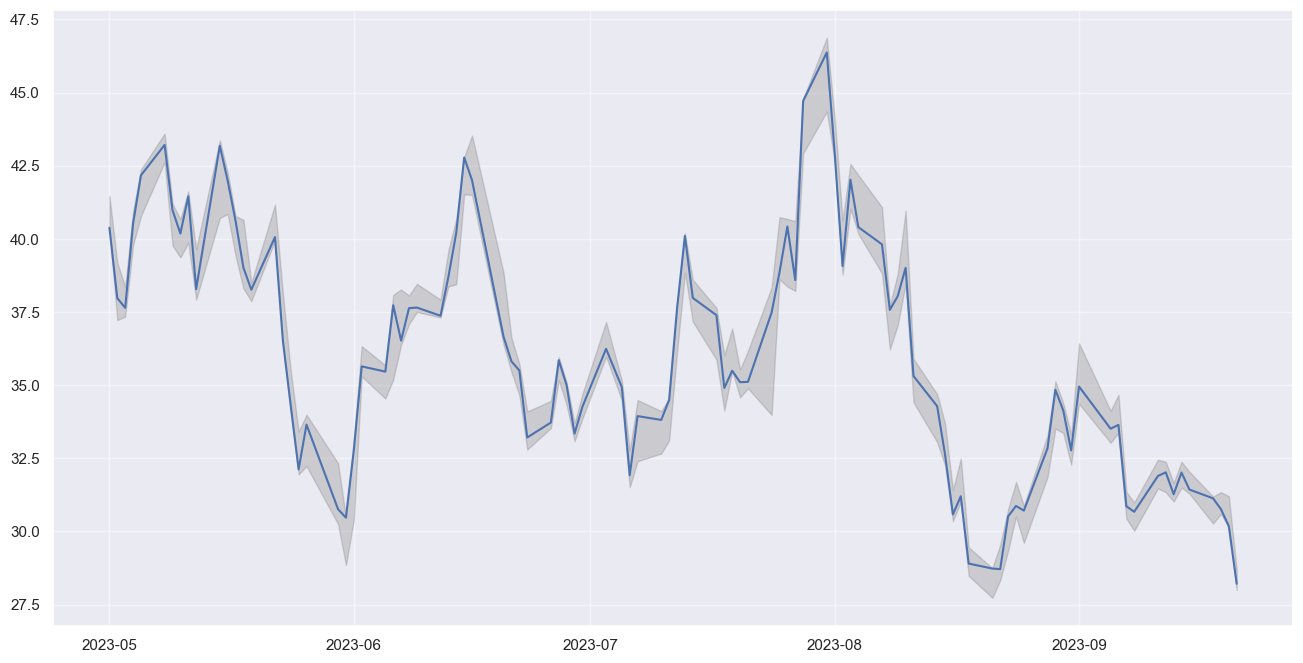

In [124]:
df_yinn = yf.download('yinn'.upper(), start='2023-05-01', end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

plt.figure(figsize=(16, 8))
plt.grid(True, alpha=0.5)

plt.plot(df_yinn['Date'], df_yinn['Close'], label='Daily Close Price')
# plt.plot(df_yinn['Date'], df_yinn['High'], color='green', label='Highest Price')
# plt.plot(df_yinn['Date'], df_yinn['Low'], color='red', label='Lowest Price')

# Shading the region between the highest and lowest prices
plt.fill_between(df_yinn['Date'], df_yinn['Low'], df_yinn['High'], color='gray', alpha=0.3, label='Daily Price Range')
plt.show()

In [125]:
df_yinn.columns = df_yinn.columns.str.lower()
df_yinn.head()


,date,open,high,low,close,adj close,volume
0,2023-05-01,40.509998,41.459999,40.320000,40.380001,40.036213,619800
1,2023-05-02,39.110001,39.180000,37.220001,37.970001,37.646732,1207800
2,2023-05-03,37.830002,38.360001,37.340000,37.639999,37.319538,928100
3,2023-05-04,39.790001,40.950001,39.790001,40.520000,40.175018,1043700
4,2023-05-05,41.330002,42.369999,40.779999,42.169998,41.810970,688300


In [126]:
import pandas as pd

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['close'][i] < data['close'][i - 1] and data['close'][i] < data['close'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['close'][i] > data['close'][i - 1] and data['close'][i] > data['close'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

# Example usage:
# Assuming you have a DataFrame named 'stock_price_dataframe' with a 'close' column
df_yinn = identify_weak_support_resistance(df_yinn)
df_yinn

,date,open,high,low,close,adj close,volume,Support/Resistance
0,2023-05-01,40.509998,41.459999,40.320000,40.380001,40.036213,619800,neither
1,2023-05-02,39.110001,39.180000,37.220001,37.970001,37.646732,1207800,neither
2,2023-05-03,37.830002,38.360001,37.340000,37.639999,37.319538,928100,weak support
3,2023-05-04,39.790001,40.950001,39.790001,40.520000,40.175018,1043700,neither
4,2023-05-05,41.330002,42.369999,40.779999,42.169998,41.810970,688300,neither
...,...,...,...,...,...,...,...,...
95,2023-09-15,31.840000,32.040001,31.290001,31.430000,31.364374,2277600,neither
96,2023-09-18,30.760000,31.190001,30.270000,31.129999,31.064999,1397800,neither
97,2023-09-19,30.930000,31.340000,30.600000,30.760000,30.760000,1460700,neither
98,2023-09-20,30.760000,31.200001,30.129999,30.180000,30.180000,1948100,neither


Optimum K is 10
Optimum K is 10
[[28.70999908]
 [30.73999977]
 [32.0199995 ]
 [32.98999977]
 [33.55333328]
 [35.15333303]
 [36.52000046]
 [37.52666601]
 [38.54999924]
 [40.18000031]]
[[31.0350008 ]
 [32.01499939]
 [33.74333318]
 [34.89500046]
 [35.80500031]
 [37.69000053]
 [39.89749908]
 [41.73500061]
 [43.05666606]
 [46.36999893]]


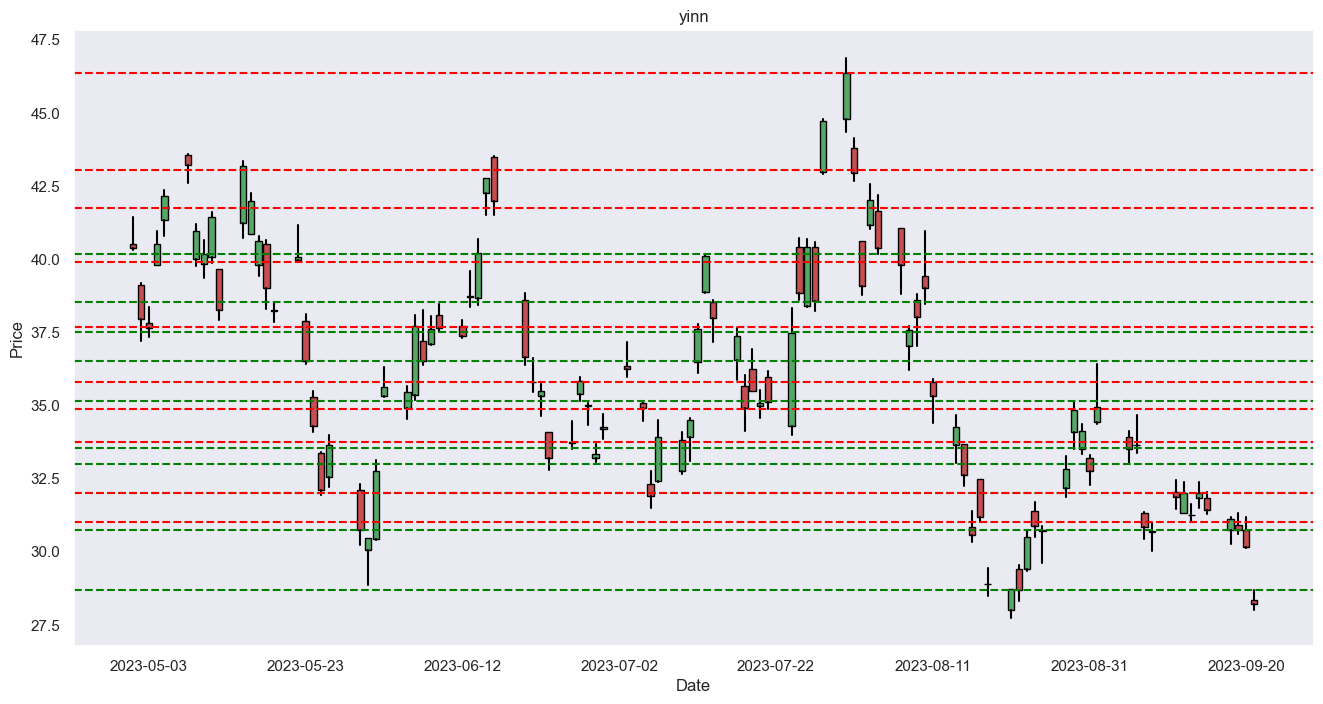

In [127]:
low_clusters = get_optimum_clusters(df_yinn[df_yinn['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[df_yinn['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

Optimum K is 10
Optimum K is 10
[[28.27799988]
 [30.17454563]
 [31.64333328]
 [33.08272726]
 [34.3566672 ]
 [35.82750003]
 [37.38444434]
 [38.66749986]
 [40.5208327 ]
 [43.13999844]]
[[29.10500002]
 [31.17545457]
 [32.72363697]
 [34.43937516]
 [35.98727278]
 [37.71666675]
 [38.78272768]
 [40.87874985]
 [42.8324995 ]
 [45.25999959]]


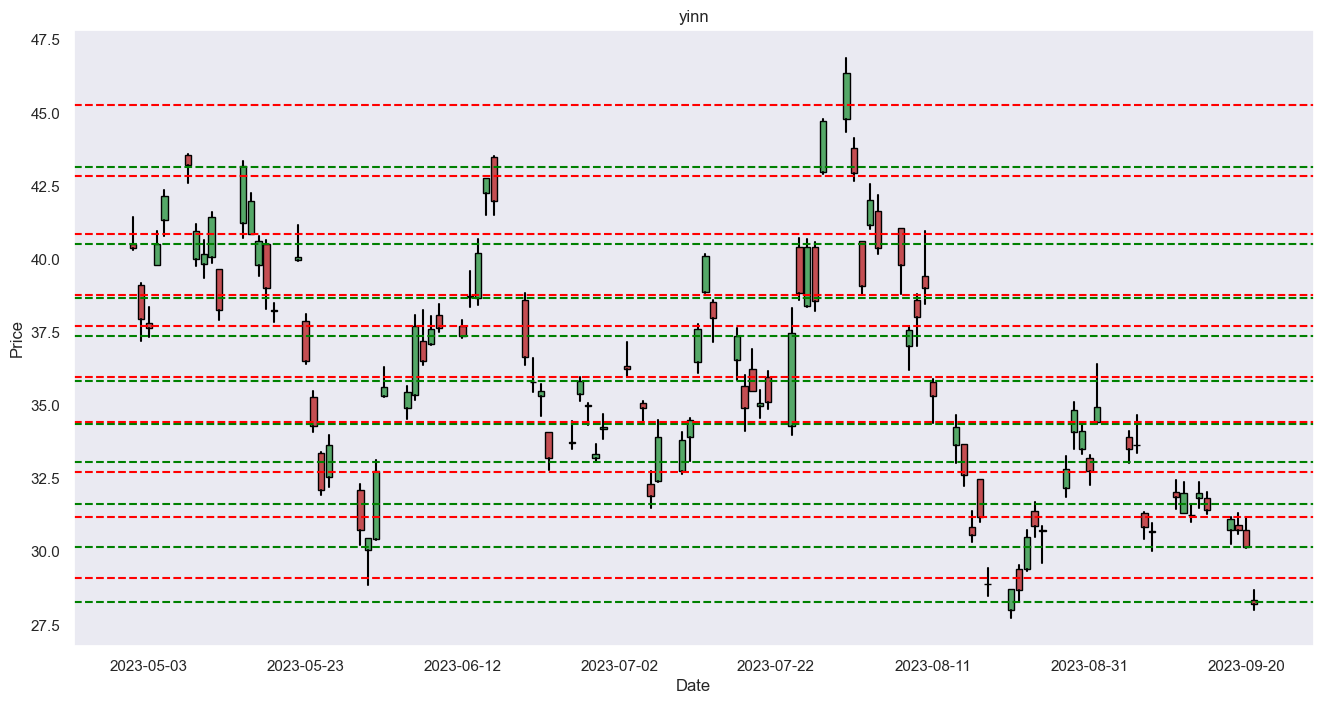

In [129]:
low_clusters = get_optimum_clusters(df_yinn[['date',"low"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[['date',"high"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

In [ ]:
def find_strong_level(df):
    closest_preceding = {}
    closest_following = {}

    last_supp_index = None
    last_resi_index = None
    
    for i, (gender, height) in enumerate(student_list):
        if gender == 'g':
            # If the current student is a girl, find the closest preceding boy
            if last_boy_index is not None:
                closest_preceding[i] = last_boy_index
            # Update the most recent girl index
            last_girl_index = i
        elif gender == 'b':
            # If the current student is a boy, find the closest preceding girl
            if last_girl_index is not None:
                closest_preceding[i] = last_girl_index
            # Update the most recent boy index
            last_boy_index = i

    # Reset the variables for tracking the most recent students
    last_girl_index = None
    last_boy_index = None

    # Iterate in reverse to find the closest following students
    for i in range(len(student_list) - 1, -1, -1):
        gender, height = student_list[i]
        if gender == 'g':
            # If the current student is a girl, find the closest following boy
            if last_boy_index is not None:
                closest_following[i] = last_boy_index
            # Update the most recent girl index
            last_girl_index = i
        elif gender == 'b':
            # If the current student is a boy, find the closest following girl
            if last_girl_index is not None:
                closest_following[i] = last_girl_index
            # Update the most recent boy index
            last_boy_index = i

    # Create a list of students with the desired format
    students_with_heights = []
    for i, (gender, height) in enumerate(student_list):
        preceding_height = student_list[closest_preceding.get(i, -1)][1] if closest_preceding.get(i, -1) != -1 else None
        following_height = student_list[closest_following.get(i, -1)][1] if closest_following.get(i, -1) != -1 else None
        students_with_heights.append([gender, height, preceding_height, following_height])

    return students_with_heights

# Example usage:
student_list = [('g', 170), ('b', 180), ('g', 160), ('b', 175), ('b', 185), ('g', 165)]
find_closest_students_with_heights(student_list)

In [21]:
df2 = pd.DataFrame()

# Number of previous days to include
num_prev_days = 10

# Loop through the dates in df_kweb
for i, row in df_kweb[df_kweb['date']>='2023-07-01'].iterrows():
    date = row['date']
    price = row['close']
    
    # Create columns for each previous day's price
    for day in range(num_prev_days):
        prev_date = date - pd.Timedelta(days=day + 1)
        prev_price = df_kweb.loc[df_kweb['date'] == prev_date, 'close'].values
        
        # Add the previous day's price to the new dataframe
        col_name = f'price_{-day - 1}day'
        df2.at[i, col_name] = prev_price[0] if len(prev_price) > 0 else None
    
    # Add the current day's price to the new dataframe
    df2.at[i, 'price_0day'] = price

# Merge the date column from df_kweb with df2
df2['date'] = df_kweb[df_kweb['date']>='2023-07-01']['date']

# Reorder the columns to have 'date' first
column_order = ['date'] + [f'price_{-day}day' for day in range(num_prev_days)]
df2 = df2[column_order]

print(df2)

           date  price_0day  price_-1day  price_-2day  price_-3day   
1383 2023-07-03   27.570000          NaN          NaN    26.930000  \
1384 2023-07-05   27.350000          NaN    27.570000          NaN   
1385 2023-07-06   26.490000    27.350000          NaN    27.570000   
1386 2023-07-07   27.480000    26.490000    27.350000          NaN   
1387 2023-07-10   27.559999          NaN          NaN    27.480000   
1388 2023-07-11   27.930000    27.559999          NaN          NaN   
1389 2023-07-12   29.129999    27.930000    27.559999          NaN   
1390 2023-07-13   30.150000    29.129999    27.930000    27.559999   
1391 2023-07-14   29.250000    30.150000    29.129999    27.930000   
1392 2023-07-17   29.080000          NaN          NaN    29.250000   
1393 2023-07-18   27.959999    29.080000          NaN          NaN   
1394 2023-07-19   28.290001    27.959999    29.080000          NaN   
1395 2023-07-20   28.070000    28.290001    27.959999    29.080000   
1396 2023-07-21   28

In [22]:
df2.head()

,date,price_0day,price_-1day,price_-2day,price_-3day,price_-4day,price_-5day,price_-6day,price_-7day,price_-8day,price_-9day
1383,2023-07-03,27.570000,NaN,NaN,26.93,26.83,27.40,27.75,26.889999,NaN,NaN
1384,2023-07-05,27.350000,NaN,27.57,NaN,NaN,26.93,26.83,27.400000,27.75,26.889999
1385,2023-07-06,26.490000,27.35,NaN,27.57,NaN,NaN,26.93,26.830000,27.40,27.750000
1386,2023-07-07,27.480000,26.49,27.35,NaN,27.57,NaN,NaN,26.930000,26.83,27.400000
1387,2023-07-10,27.559999,NaN,NaN,27.48,26.49,27.35,NaN,27.570000,NaN,NaN
